In [1]:
# imports of necessary packages
from domains.TourDeFlags import TourDeFlags
from exploration.DecayingEpsilon import DecayingEpsilon
from agents.DeepAgent import DeepAgent
from training.Trainer import Trainer

import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

C:\Users\Michael\Dropbox\rl\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:
# set up the domain
maze = np.array([
        [0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0],
        [0, 0, -1, 2, 0, 0, 0, 0, -1, 4, 0],
        [0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0],
        [0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0],
        [0, 0, -1, 0, 0, -1, 0, 0, -1, 0, 0],
        [0, 0, -1, 0, 0, -1, 3, 0, -1, 0, 0],
        [0, 0, -1, 0, 0, -1, 0, 0, -1, 0, 0],
        [0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 5]
    ])
domain = TourDeFlags(maze, (5, 0))

# use the default encoding
encoding = domain.default_encoding

In [3]:
# now we will define the shaping functions from these networks
# we use Phi0 and Phi1 from Ng, Harada and Russell's 1999 ICML paper 
# "Policy invariance under reward transformations: Theory and application to reward shaping"
# it would be interesting to see whether we can identify different qualities of intuition
# however, note that the "good" shaping function used here is for a somewhat different problem
# with walls, so it is also an approximation. in fact, it's not clear whether Phi0 or Phi1
# is better
def zero_shape(state):
    return 0.0

def heuristic_shape(state):
    row, col, collected = state
    if collected == 0:
        return -abs(row - 10) - abs(col - 4) - 38.0
    elif collected == 1:
        return -abs(row - 1) - abs(col - 3) - 28.0
    elif collected == 2:
        return -abs(row - 5) - abs(col - 6) - 21.0
    elif collected == 3:
        return -abs(row - 1) - abs(col - 9) - 10.0
    elif collected == 4:
        return -abs(row - 10) - abs(col - 10)
    else:
        return 0.0
    
def heuristic_shape2(state):
    return -47.0 * ((5.0 - state[2] - 0.5) / 5.0)

def bad_shape(state):
    return 47.0 * ((5.0 - state[2] - 0.5) / 5.0)

def random_shape(state):
    return -random.random()

In [4]:
# we will define the success criterion and stopping rule
# since we will be taking an average of many trials, we don't do early stopping
def steps_to_goal(maze, policy, enc):
    state = maze.initial_state()
    state_enc = enc(state)
    steps = 0
    while steps < maze.max_steps:
        action = policy(state_enc)
        state, reward, done = maze.act(state, action)
        state_enc = enc(state)
        steps += 1
        if done:
            break
    return steps, False

In [5]:
# set up the neural network as the function approximator
model = Sequential()
model.add(Dense(maze.size,
                input_shape=(domain.state_dim(), ),
                activation='relu'))
model.add(Dense(maze.size,
                activation='relu'))
model.add(Dense(domain.action_count()))
model.compile(optimizer=Adam(0.001), loss='mse')
print(model.summary())

# set up the exploration schedule for the greedy epsilon policy
eps_schedule = DecayingEpsilon(0.5, 0.05, 0.99)

# set up the learning agent
agent = DeepAgent(domain.state_dim(), domain.action_count(), 1.0)
agent.setup_nn(batch_size=32, 
               epochs_per_batch=4,
               memory_size=10000, 
               network=model)

# finally create the training algorithm
training = Trainer(domain, agent, encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 121)               3509      
_________________________________________________________________
dense_2 (Dense)              (None, 121)               14762     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 488       
Total params: 18,759
Trainable params: 18,759
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# we start by training for 1 trial on all the experts and sarsa
# this can take 20 minutes to train
experts = [zero_shape, heuristic_shape, heuristic_shape2, random_shape, bad_shape]
data_sarsa = training.run_many(trials=1, epochs=150, horizon=domain.max_steps,
                               exploration=eps_schedule, experts=experts,
                               method='sarsa', 
                               replay_online_every=1, replays_offline=0,
                               measure=steps_to_goal)

Trial 0 complete.


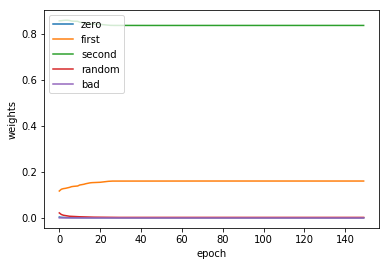

In [7]:
# now let's plot the bayesian weights
plt.xlabel('epoch')
plt.ylabel('weights')
legend_labels = ['zero', 'first', 'second', 'random', 'bad']
for i, series in enumerate(data_sarsa['weights']):
    plt.plot(series, label=legend_labels[i])
plt.legend(loc='upper left')
plt.show()

In [8]:
# Interestingly, it puts almost all it's weights on the second expert and not the first. 
# I guess ignoring the barriers induces a large error and doesn't fit to the value 
# function well, whereas the "midpoint" rule is more accurate

In [10]:
# the benchmark
data_sarsa_bench = training.run_many(trials=1, epochs=150, horizon=domain.max_steps,
                                     exploration=eps_schedule, experts=[zero_shape],
                                     method='sarsa', 
                                     replay_online_every=1, replays_offline=0,
                                     measure=steps_to_goal)

Trial 0 complete.


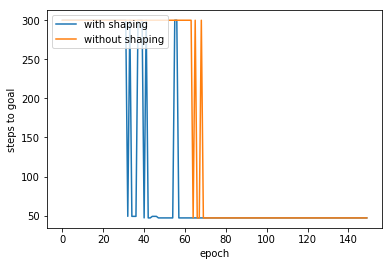

In [14]:
# let's plot the progress
plt.xlabel('epoch')
plt.ylabel('steps to goal')
plt.plot(data_sarsa['measure'], label='with shaping')
plt.plot(data_sarsa_bench['measure'], label='without shaping')
plt.legend(loc='upper left')
plt.show()

In [15]:
# so with shaping we can obtain the optimal policy faster than without.
# I would hope to see the same result over many trials

In [ ]:
# I will need more trials to verify that learning is faster with shaping